# Problem 1

In [1]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(
    root="mnist_data", train=True, transform=transforms, download=True
)

valid_dataset = datasets.MNIST(root="mnist_data", train=False, transform=transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 28753572.95it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77800702.52it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23767991.74it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18091670.25it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



## 1.1.1

Text(10, -2, 'The label is 5')

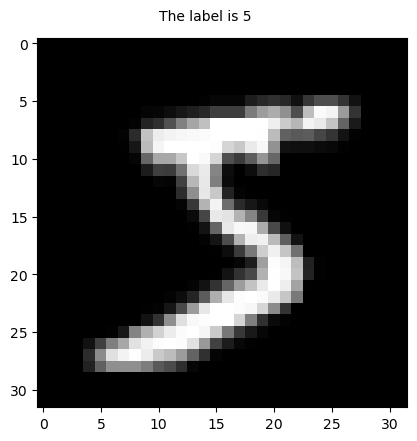

In [6]:
plt.imshow(train_dataset[0][0].squeeze(), cmap="gray")
plt.text(10, -2, "The label is " + str(train_dataset[0][1]))

In [8]:
# hyper parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

## 1.1.2

In [10]:
# define the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 1.1.3

In [11]:
def train(train_loader, model, criterion, optimizer):
    """
    Train one epoch.
    """

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

## 1.1.4

In [12]:
def validate(valid_loader, model, criterion):
    """
    Function for the validation step of the training loop.
    Returns the model and the loss on the test set.
    """

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

In [13]:
def training_loop(
    model, criterion, optimizer, train_loader, valid_loader, epochs, print_every=1
):
    """
    Function defining the entire training loop
    """

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(
                model,
                train_loader,
            )
            train_accs.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader)
            valid_accs.append(valid_acc)

            print(
                f"{datetime.now().time().replace(microsecond=0)} "
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}"
            )

    performance = {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

    return model, optimizer, performance

## 1.1.5

In [38]:
def get_accuracy(model, data_loader):
    """
    Function for computing the accuracy of the predictions over the entire data_loader
    """

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


def plot_performance(performance):
    """
    Function for plotting training and validation losses
    """

    # temporarily change the style of the plots to seaborn
    # plt.style.use("seaborn")

    fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))
    for key, value in performance.items():
        if "loss" in key:
            ax[0].plot(value, label=key)
        else:
            ax[1].plot(value, label=key)
    ax[0].set(title="Loss  over epochs", xlabel="Epoch", ylabel="Loss")
    ax[1].set(title="accuracy over epochs", xlabel="Epoch", ylabel="Loss")
    ax[0].legend()
    ax[1].legend()
    plt.show()

    # change the plot style to default
    plt.style.use("default")

## 1.2.1

In [16]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.2.2

In [17]:
class MLP(nn.Module):

    def __init__(self, layers):
        super(MLP, self).__init__()

        self.all_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.all_layers.append(
                nn.Linear(in_features=layers[i - 1], out_features=layers[i])
            )
            if i != len(layers) - 1:
                self.all_layers.append(nn.Tanh())
        self.all_layers = nn.Sequential(*self.all_layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.all_layers(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.3.1

In [20]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [44]:
model, optimizer, performance_1 = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS
)

23:06:43 Epoch: 0	Train loss: 0.0101	Valid loss: 0.1160	Train accuracy: 99.51	Valid accuracy: 97.60
23:06:50 Epoch: 1	Train loss: 0.0136	Valid loss: 0.1009	Train accuracy: 99.59	Valid accuracy: 97.56
23:06:58 Epoch: 2	Train loss: 0.0076	Valid loss: 0.0971	Train accuracy: 99.82	Valid accuracy: 97.95
23:07:05 Epoch: 3	Train loss: 0.0119	Valid loss: 0.1018	Train accuracy: 99.76	Valid accuracy: 97.93
23:07:12 Epoch: 4	Train loss: 0.0094	Valid loss: 0.1074	Train accuracy: 99.59	Valid accuracy: 97.90
23:07:19 Epoch: 5	Train loss: 0.0111	Valid loss: 0.0970	Train accuracy: 99.68	Valid accuracy: 97.96
23:07:26 Epoch: 6	Train loss: 0.0091	Valid loss: 0.1039	Train accuracy: 99.73	Valid accuracy: 97.68
23:07:33 Epoch: 7	Train loss: 0.0092	Valid loss: 0.0960	Train accuracy: 99.85	Valid accuracy: 97.89
23:07:40 Epoch: 8	Train loss: 0.0057	Valid loss: 0.1049	Train accuracy: 99.73	Valid accuracy: 97.73
23:07:47 Epoch: 9	Train loss: 0.0107	Valid loss: 0.1049	Train accuracy: 99.72	Valid accuracy: 97.89


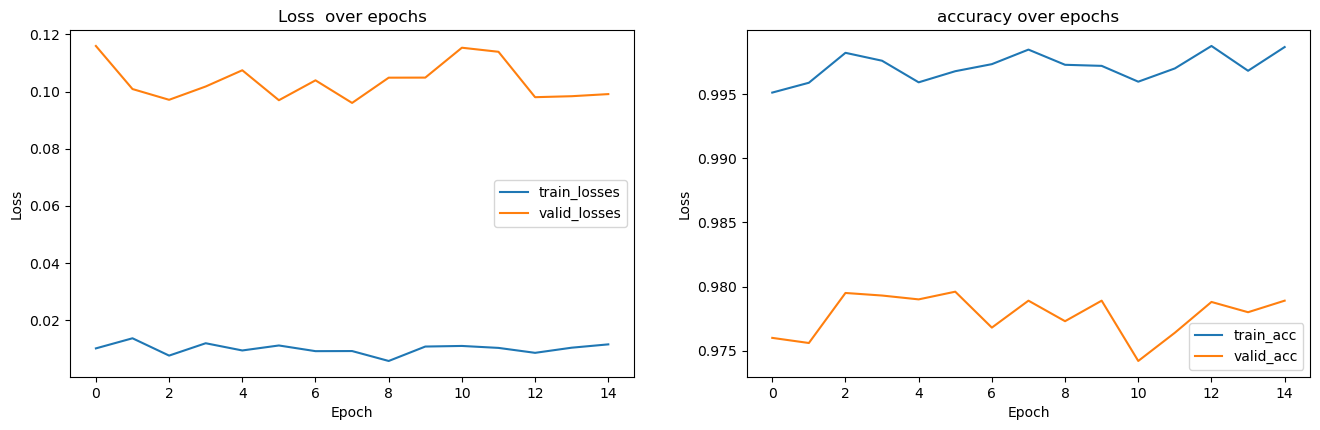

In [47]:
plot_performance(performance_1)

## 1.3.2

In [22]:
torch.manual_seed(RANDOM_SEED)
layers = [1024, 256, 64, 16, N_CLASSES]
model = MLP(layers)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

MLP(
  (all_layers): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [43]:
model, optimizer, performance_2 = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS
)

23:04:55 Epoch: 0	Train loss: 0.0134	Valid loss: 0.0908	Train accuracy: 99.83	Valid accuracy: 98.03
23:05:02 Epoch: 1	Train loss: 0.0109	Valid loss: 0.0927	Train accuracy: 99.69	Valid accuracy: 97.85
23:05:09 Epoch: 2	Train loss: 0.0126	Valid loss: 0.1026	Train accuracy: 99.53	Valid accuracy: 97.42
23:05:16 Epoch: 3	Train loss: 0.0125	Valid loss: 0.1047	Train accuracy: 99.51	Valid accuracy: 97.57
23:05:23 Epoch: 4	Train loss: 0.0130	Valid loss: 0.0873	Train accuracy: 99.71	Valid accuracy: 98.07
23:05:30 Epoch: 5	Train loss: 0.0121	Valid loss: 0.1040	Train accuracy: 99.46	Valid accuracy: 97.59
23:05:38 Epoch: 6	Train loss: 0.0111	Valid loss: 0.0996	Train accuracy: 99.50	Valid accuracy: 97.72
23:05:44 Epoch: 7	Train loss: 0.0107	Valid loss: 0.0999	Train accuracy: 99.49	Valid accuracy: 97.73
23:05:52 Epoch: 8	Train loss: 0.0127	Valid loss: 0.0943	Train accuracy: 99.74	Valid accuracy: 97.89
23:05:59 Epoch: 9	Train loss: 0.0101	Valid loss: 0.1025	Train accuracy: 99.51	Valid accuracy: 97.71


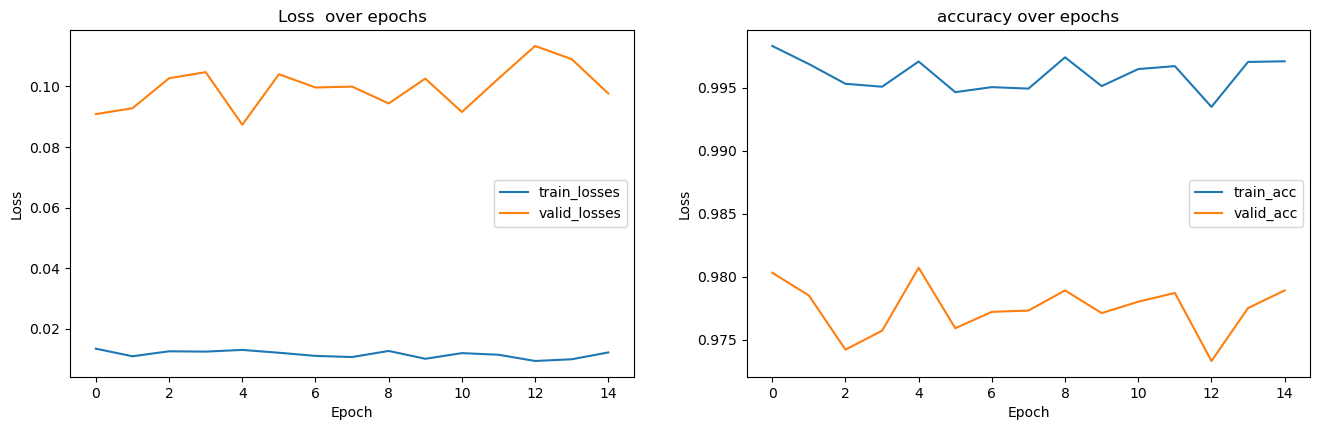

In [46]:
plot_performance(performance_2)

## 1.4 Comparison of these two models.

1.What is the number of trainable parameters of LeNet? 5 points

- Convolutional Layers 1: (551+1) \* 6 = 156
- Convolutional Layers 2: (55\*6+1)16 = 2416
- Convolutional Layers 3: (55\*16+1)120 = 48120
- Fully Connected Layers 1: 120\*84+84 = 10164
- Fully Connected Layers 2: 84\*10+10 = 850
- Total: 61706

  2.What is the number of trainable parameters of MLP? 5 points

- Fully Connected Layers 1: 1024\*256+256
- Fully Connected Layers 2: 256\*64+64
- Fully Connected Layers 3: 64\*16+16
- Last Fully Connected Layers: 16\*10+10
- Total: 280058

  3.Which model has better performance in terms of prediction accuracy on the test data? Give a reason why
  this model works better than the other. 10 points

LeNet is better.

When using MLP to process images, it is often necessary to flatten the image from its original form into a one-dimensional vector. This flattening process destroys the spatial relationship between pixels.

LeNet is able to understand the spatial relationship between pixels in an image


# Statement of Collaboration (5 points)

I do it by myself.
